## Brain-MDD Project
- Capstone Project

In [1]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

In [3]:
# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
rawDataPath = os.getenv("EEG_DIR_PATH") + "/raw"
eeg16ChannelPath = os.getenv("EEG_DIR_PATH") + "/16channels"
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
reportPath = os.getenv("EEG_REPORT_PATH")
epochsPath = os.getenv("EEG_DIR_PATH") + "/epochs"

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
reportDf["subject id"] = reportDf["subject id"].astype(str)
print(type(reportDf["subject id"][0]))

<class 'str'>


## Preprocessing
- Channel selection
- 5th-Order Butterworth bandpass filter
- ICA (next sprint)
- save as .fif file format + map with label
- do epoch

In [ ]:
# select the channels of interest; 16 channels
for file in os.listdir(rawDataPath):
    if file.endswith(".npy"):
        data = np.load(rawDataPath + "/" + file)
        selectedChannelsEeg = []
        for channel in ChannelMapping:
            selectedChannelsEeg.append(data[channel.value])
        selectedChannelsEeg = np.array(selectedChannelsEeg)
        print(selectedChannelsEeg.shape)
        np.save(eegPath + "/16channels/" + file, selectedChannelsEeg)

In [ ]:
channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ["eeg"] * len(channelNames)
sfreq = 250

# filtering and saving the data
for eeg16ChannelFile in os.listdir(eeg16ChannelPath):
    if eeg16ChannelFile.endswith(".npy"):
        data = np.load(eeg16ChannelPath + "/" + eeg16ChannelFile)
        info = mne.create_info(channelNames, sfreq, channelTypes)
        raw = mne.io.RawArray(data, info)
        
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage)
        
        raw.filter(0.5, 40) # Bandpass filter 0.5 - 40 Hz
        
        # ica = mne.preprocessing.ICA(n_components=16, random_state=97, max_iter=800)
        # ica.fit(raw)
        # raw = ica.apply(raw)
        
        eeg16ChannelFile = eeg16ChannelFile.split(".")[0]
        raw.save(eegPath + "/filtered/" + eeg16ChannelFile + ".fif", overwrite=True)

In [ ]:
# map data with labels
mddDataLst = []
controlDataLst = []

# file name is matched with the "subject id" and label is "type"
for file in os.listdir(filteredDataPath):
    if file.endswith(".fif"):
        subjectId = file.split(".")[0]
        subjectId = subjectId[1:]
        subjectId = str(subjectId)
        result = reportDf[reportDf['subject id'] == subjectId]
        if result.empty:
            continue
        label = result["type"].values[0]
        if label == "MDD":
            mddDataLst.append(subjectId)
        elif label == "HC":
            controlDataLst.append(subjectId)
        os.rename(filteredDataPath + "/" + file, filteredDataPath + "/" + subjectId + "_" + label + ".fif")

In [ ]:
# do epoch
healthyControlEpochs = []
mddEpochs = []

# fs = 250, duration = 5s, samples = 250 * 5 = 1250
for file in os.listdir(filteredDataPath):
    if file.endswith(".fif"):
        raw = mne.io.read_raw_fif(filteredDataPath + "/" + file)
        subjectId = file.split("_")[0]
        label = file.split("_")[1].split(".")[0]
        if label == "MDD":
            mddEpochs.append(mne.make_fixed_length_epochs(raw, duration=5, preload=True))
        elif label == "HC":
            healthyControlEpochs.append(mne.make_fixed_length_epochs(raw, duration=5, preload=True))
            
# save the epochs
mddEpochs = mne.concatenate_epochs(mddEpochs)
healthyControlEpochs = mne.concatenate_epochs(healthyControlEpochs)
mddEpochs.save(epochsPath + "/mdd-epo.fif")
healthyControlEpochs.save(epochsPath + "/control-epo.fif")

## Feature Extraction

In [11]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.psd import EEGPowerSpectrum
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Feature Dictionary
featureDict = {
    "norm_power": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    }    

# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
rawDataPath = os.getenv("EEG_DIR_PATH") + "/raw"
eeg16ChannelPath = os.getenv("EEG_DIR_PATH") + "/16channels"
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
epochsPath = os.getenv("EEG_DIR_PATH") + "/epochs"

In [2]:
# Load the epochs
mddEpochs = mne.read_epochs(epochsPath + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(epochsPath + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()

Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/mdd-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/control-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated


In [12]:
psdObjMdd = EEGPowerSpectrum(mddEpochs, 250, ifNormalize=True)
mddPsdFeatures = psdObjMdd.run()
psdObjCtrl = EEGPowerSpectrum(controlEpochs, 250, ifNormalize=True)
controlPsdFeatures = psdObjCtrl.run()
print(mddPsdFeatures.shape)
print(controlPsdFeatures.shape)

(1328, 5, 16)
(1753, 5, 16)


In [13]:
for epoch in mddPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["mdd"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["mdd"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["mdd"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["mdd"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["mdd"]["gamma"].append(band)
        bandCounter += 1

for epoch in controlPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["control"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["control"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["control"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["control"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["control"]["gamma"].append(band)
        bandCounter += 1                                                           

In [14]:
# check the shape of the features
print(type(featureDict["norm_power"]["mdd"]["delta"]))
print(len(featureDict["norm_power"]["mdd"]["delta"]))
print(type(featureDict["norm_power"]["mdd"]["delta"][0]))
print((featureDict["norm_power"]["mdd"]["delta"][0].shape))
print(featureDict["norm_power"]["mdd"]["delta"][0])

print("------------------")

print(type(featureDict["norm_power"]["control"]["delta"]))
print(len(featureDict["norm_power"]["control"]["delta"]))
print(type(featureDict["norm_power"]["control"]["delta"][0]))
print((featureDict["norm_power"]["control"]["delta"][0].shape))
print(featureDict["norm_power"]["control"]["delta"][0])

<class 'list'>
1328
<class 'numpy.ndarray'>
(16,)
[0.83056823 0.87734384 0.90729667 0.87926266 0.90732366 0.40353021
 0.84019323 0.67680983 0.72123247 0.42196012 0.83618242 0.91446568
 0.75412763 0.59408818 0.42842383 0.66620692]
------------------
<class 'list'>
1753
<class 'numpy.ndarray'>
(16,)
[0.98623744 0.98451825 0.98785362 0.98789097 0.99189221 0.96553099
 0.99675056 0.37090386 0.99507843 0.36207738 0.99450565 0.98194598
 0.96151343 0.94749412 0.99297081 0.8671709 ]


## Classification

0.6532220676866017
         f1  precision    recall  accuracy  sensitivity  specificity
0  0.653222   0.653222  0.653222  0.653222     0.768233     0.499458


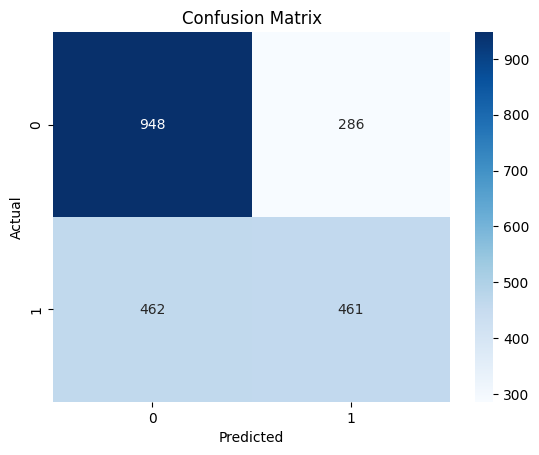

In [16]:
# train lda model from skimlearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Prepare the data
deltaMdd = featureDict["norm_power"]["mdd"]["delta"]
deltaControl = featureDict["norm_power"]["control"]["delta"]
deltaMdd = np.array(deltaMdd)
deltaControl = np.array(deltaControl)

X = np.concatenate((deltaMdd, deltaControl), axis=0)
y = np.concatenate((np.ones(len(deltaMdd)), np.zeros(len(deltaControl))), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=500)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(lda.score(X_test, y_test))
# show df of f1-score, precision, recall, accuracy


y_pred = lda.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

f1 = 2 * (lda.score(X_test, y_test) * lda.score(X_test, y_test)) / (lda.score(X_test, y_test) + lda.score(X_test, y_test))
precision = lda.score(X_test, y_test) / (lda.score(X_test, y_test) + 1 - lda.score(X_test, y_test))
recall = lda.score(X_test, y_test) / (lda.score(X_test, y_test) + 1 - lda.score(X_test, y_test))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
accuracy = lda.score(X_test, y_test)

# show as dataframe
df = pd.DataFrame({
    "f1": [f1],
    "precision": [precision],
    "recall": [recall],
    "accuracy": [accuracy],
    "sensitivity": [sensitivity],
    "specificity": [specificity]
})
print(df)

# Create a mesh grid
# X_vis = X[:, :2]
# x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
# y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
# Z = Z.reshape(xx.shape)

# plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', label='Train')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='x', label='Test')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('LDA Decision Boundary')
# plt.legend()

plt.show()